# Group-based Classification Models

### Importing libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import os
import sys

In [2]:
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [3]:
import sklearn
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [4]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt

In [5]:
from pycaret.classification import *

In [6]:
import functions as f

In [7]:
from copy import deepcopy

In [8]:
categorical_columns = ['NP_type', 'Coating','shape','Cell_name','Cell_species','cell_Organ','Cell_morphology',
                       'Cell_age','cell_type','sex','Assay','Test_indicator']
numerical_columns = ['core_size_nm','hydro_size_nm','Surf_charge_mV','Surface_area_m2_g','Dose_microg_mL','Duration_h',
                    'Viability']

numerical_columns_no_target = ['core_size_nm','hydro_size_nm','Surf_charge_mV','Dose_microg_mL','Duration_h']

# Carbon-based NMs classification model

In [9]:
model_group_name = "carbon_based"
group_name = "carbon"

### Load the data and filter instances

In [10]:
data_train_df = pd.read_csv("output/datasets/universal/data_classification_train_df.csv", encoding="utf-8")
data_test_df = pd.read_csv("output/datasets/universal/data_classification_test_df.csv", encoding="utf-8")
data_df = pd.concat([data_train_df,data_test_df])

del data_train_df
del data_test_df

In [11]:
data_df.shape

(4656, 20)

In [12]:
data_group_df = data_df[data_df['nanomaterial_group'] == group_name]

In [13]:
data_group_df.shape

(116, 20)

In [14]:
data_group_df.head()

,NP_type,Coating,core_size_nm,hydro_size_nm,Surf_charge_mV,Surface_area_m2_g,shape,Dose_microg_mL,Duration_h,Cell_name,Cell_species,cell_Organ,Cell_morphology,Cell_age,cell_type,sex,Assay,Test_indicator,nanomaterial_group,viability_class
0,Carbon,None,53.70,NaN,-39.9,NaN,Sphere,50.0,24.0,THP_1,Human,Blood,monocyte,neonate,cancer,male,MTT,TetrazoliumSalt,carbon,NonToxic
5,C60,None,34.64,142.0,-37.4,NaN,Sphere,0.1,6.0,mDF,Mouse,Skin,Fibroblast,Adult,Normal,NaN,MTT,TetrazoliumSalt,carbon,NonToxic
91,Diamond,None,4.00,NaN,-35.6,NaN,Sphere,100.0,2.0,C3A,Human,Liver,Epithelial,Adult,cancer,male,MTT,TetrazoliumSalt,carbon,NonToxic
104,C60,None,34.64,142.0,-37.4,NaN,Sphere,1.0,48.0,hPDLF,Human,Teeth,Fibroblast,Adult,cancer,NaN,MTT,TetrazoliumSalt,carbon,NonToxic
154,C70,None,8.00,NaN,-20.0,NaN,Sphere,5.0,24.0,V79,Hamster,Lung,Fibroblast,Adult,Normal,male,MTT,TetrazoliumSalt,carbon,NonToxic


### Create training set and test set

In [15]:
splitter = setup(data = data_group_df, target = 'viability_class',
                 preprocess = False,
                 train_size=0.8,
                 data_split_stratify=True,
                 # don't change the following
                 session_id = 123,
                 use_gpu=False,
                 log_experiment = False,
                 silent=True,
                 experiment_name = 'splitter')

,Description,Value
0,session_id,123
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,"NonToxic: 0, Toxic: 1"
4,Original Data,"(116, 20)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,14
8,Transformed Train Set,"(92, 18)"
9,Transformed Test Set,"(24, 18)"


In [16]:
data_group_train_df = get_config(variable="X_train").copy()
data_group_train_df['viability_class'] = get_config(variable="y_train").copy()

data_group_test_df = get_config(variable="X_test").copy()
data_group_test_df['viability_class'] = get_config(variable="y_test").copy()

In [17]:
print(data_group_train_df.shape)
print(data_group_test_df.shape)

(92, 19)
(24, 19)


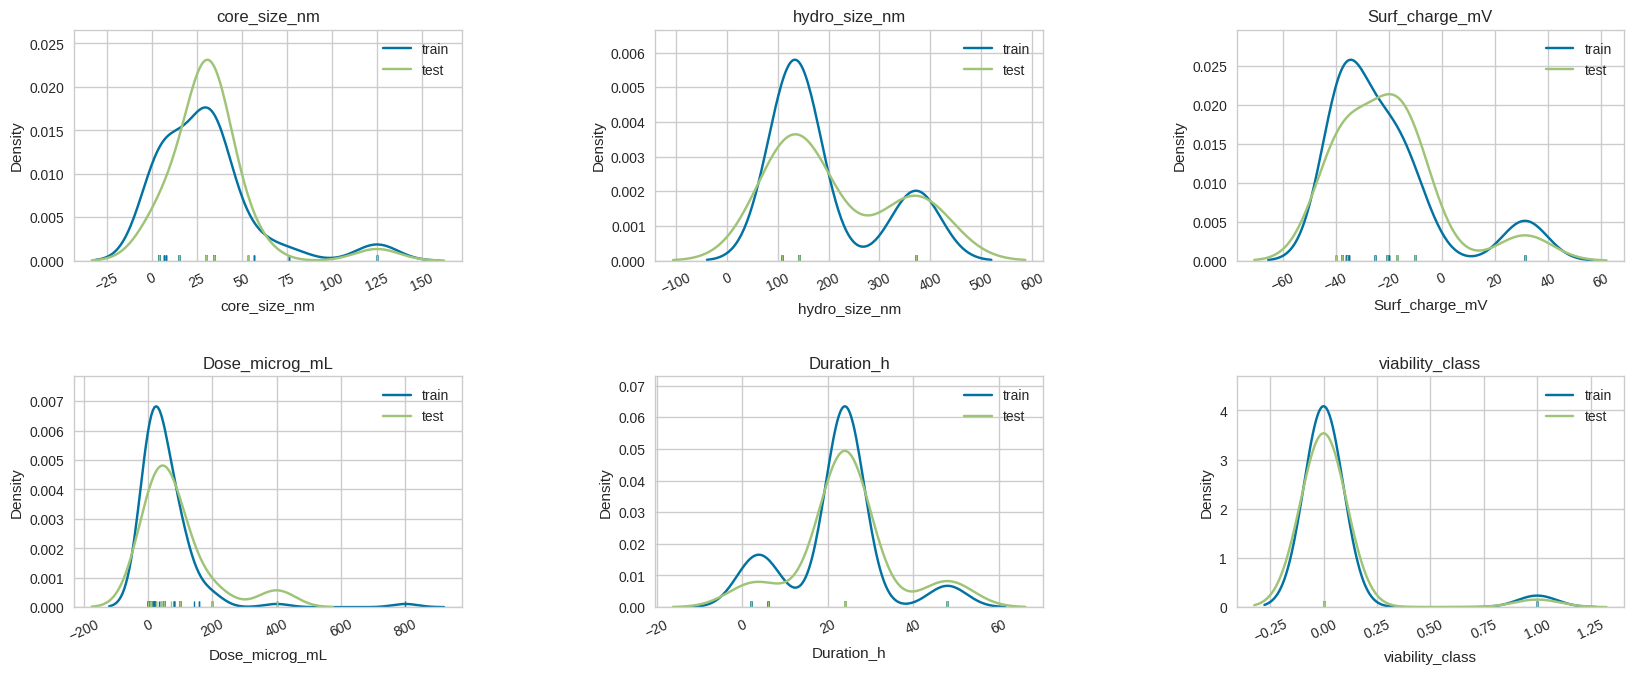

In [18]:
f.plot_distribution_train_test(data_group_train_df, data_group_test_df)

### Save cleaned datasets

In [19]:
data_group_train_df.to_csv('output/datasets/'+model_group_name+'/data_classification_train_df.csv', encoding='utf-8', index=False)

In [20]:
data_group_test_df.to_csv('output/datasets/'+model_group_name+'/data_classification_test_df.csv', encoding='utf-8', index=False)

### Use the best scenario identified in step 01

In [21]:
sc_ignore_features = None
sc_bin_numeric_features = None
sc_high_cardinality_features = None

sc_imputation_type = 'simple'
sc_numeric_imputation = 'mean'

sc_normalize = True
sc_remove_outliers = False

### Define seeds

In [22]:
cv_inner_seed = 123456
cv_outer_seed = 123

### Data Preprcoessing

In [23]:
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(k_neighbors=3, n_jobs=None, random_state=cv_inner_seed, sampling_strategy='auto')

In [24]:
stup = setup(data = data_group_train_df, target = 'viability_class', 
              
        test_data = data_group_test_df,
             
        categorical_features=categorical_columns,
        numeric_features=numerical_columns_no_target,

        imputation_type = sc_imputation_type, 
        numeric_imputation = sc_numeric_imputation, #default: mean

        ignore_features = sc_ignore_features,
        bin_numeric_features = sc_bin_numeric_features,
        high_cardinality_features = sc_high_cardinality_features,

        normalize = sc_normalize, #default: False
        remove_outliers= sc_remove_outliers, #default: False

        transformation= False, #default
        transformation_method = 'yeo-johnson', #default
        combine_rare_levels = False,
        rare_level_threshold = 0.1, #default: 0.1

        remove_multicollinearity = False, #default 
        multicollinearity_threshold = 0.9, #default

        ignore_low_variance = True, 

        feature_interaction = False, 
        feature_ratio = False,
        polynomial_features = False, 
        trigonometry_features = False,

        fix_imbalance = True,
        #fix_imbalance_method = smote,
        fold = 5,

        # don't change the following
        session_id = cv_inner_seed,
        use_gpu=False,
        log_experiment = False,
        silent=True,
        experiment_name = 'group_based')

set_config('seed', cv_inner_seed)

,Description,Value
0,session_id,123456
1,Target,viability_class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(92, 19)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,13
8,Ordinal Features,False
9,High Cardinality Features,False


In [25]:
#stup[39].steps[0][1].k_neighbors = 3

In [26]:
#stup[39].steps[0][1].k_neighbors

In [27]:
print(get_config(variable="X_train").shape)
print(get_config(variable="y_train").shape)

(92, 31)
(92,)


In [28]:
print(get_config(variable="X").shape)
print(get_config(variable="y").shape)

(92, 31)
(92,)


In [29]:
#set_config('X_train', get_config(variable="X").copy()) 
#set_config('y_train', get_config(variable="y").copy()) 
#print(get_config(variable="X_train").shape)
#print(get_config(variable="y_train").shape)

In [30]:
print(get_config(variable="X_test").shape)
print(get_config(variable="y_test").shape)

(24, 31)
(24,)


In [31]:
#load_config('output/models/universal_classification_config.cfg')

In [32]:
data_train_transformed_df = get_config(variable="X").copy()
data_train_transformed_df['Viability'] = get_config(variable="y").copy()

In [33]:
data_test_transformed_df = get_config(variable="X_test").copy()
data_test_transformed_df['Viability'] = get_config(variable="y_test").copy()

In [34]:
data_train_transformed_df.to_csv('output/datasets/'+model_group_name+'/transformed/data_classification_train_transformed_df.csv', encoding='utf-8', index=False)
data_test_transformed_df.to_csv('output/datasets/'+model_group_name+'/transformed/data_classification_test_transformed_df.csv', encoding='utf-8', index=False)

## Double cross-validation

### Inner CV: 5-fold cross-validation for model selection / hyperparameter tuning for 7 models

In [35]:
#model_names = ['lr', 'knn', 'svm', 'rf', 'et', 'gbc', 'lightgbm']
model_names = ['knn', 'svm', 'rf', 'et', 'gbc', 'lightgbm']

In [36]:
inner_results = dict()
inner_results_tuned = dict()
outer_results = dict()
predicted_results = dict()
tuned_models = dict()
final_models = dict()

In [37]:
for model_name in model_names:

    default_model = create_model(model_name, round=2)

    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    inner_results[model_name] = results_df.copy()
    results_df.to_csv('output/models_results/'+model_group_name+'/' + "classification_model_"+model_name+"_inner_cross_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")


    tuned_model = tune_model(default_model, choose_better = True, search_library = 'optuna', n_iter = 50, round=2)

    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    inner_results_tuned[model_name] = results_df.copy()
    results_df.to_csv('output/models_results/'+model_group_name+'/' + "classification_model_"+model_name+"_tuned_inner_cross_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")
    
    tuned_models[model_name] = deepcopy(tuned_model)

IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:20:53
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Fold,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6

### Outer CV: 10-fold cross-validation for the tuned model

In [ ]:
X = get_config(variable="X_train").copy()
y = get_config(variable="y_train").copy()

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=cv_outer_seed)

In [ ]:
for model_name in model_names:
    scores = cross_validate(tuned_models[model_name], X, y, cv=cv_outer, scoring=('f1','accuracy','roc_auc'))
    scores_f1 = np.round(scores['test_f1'], 2);
    scores_accuracy = np.round(scores['test_accuracy'], 2);
    scores_roc_auc = np.round(scores['test_roc_auc'], 2);
    outer_results[model_name] = scores.copy()
    
    with open('output/models_results/'+model_group_name+'/' + "classification_model_"+model_name+"_tuned_outer_cross_validation_results.tsv", 'w', newline='') as file:
        file.write('F1\tAccuracy\tAUC' + "\n")
        for idx, x in enumerate(scores_f1):
            file.write(str(scores_f1[idx]) + '\t' + str(scores_accuracy[idx]) + '\t' + str(scores_roc_auc[idx]) + "\n")

    print(model_name + " scores: " + ', '.join(scores_f1.astype('str')))
    print(model_name + " mean/std: " + str(np.round(scores_f1.mean(),2)) + " / " + str(np.round(scores_f1.std(), 2)))
    
    #with open(the_filename, 'r') as f:
    #    my_list = [line.rstrip('\n') for line in f]

### Finalize the models and evaluate on the test set

In [ ]:
for model_name in model_names:

    final_model = finalize_model(tuned_models[model_name])
    
    final_models[model_name] = deepcopy(final_model)
    
    hyperparams = pd.DataFrame.from_dict(final_model.get_params(), orient='index', columns=['parameter_value'])
    hyperparams = hyperparams.reset_index(level=0)
    hyperparams.to_csv('output/models_parameters/'+model_group_name+'/' + "classification_model_"+model_name+"_hyperparams.tsv", 
                    index=False, encoding="utf-8", sep="\t")
    
    model_predict = predict_model(final_model, round=2)
    
    results_df = pull()
    results_df = results_df.reset_index(level=0)
    
    predicted_results[model_name] = results_df.copy()
    results_df.to_csv('output/models_results/'+model_group_name+'/' + "classification_model_"+model_name+"_test_set_validation_results.tsv", 
                    index=False, encoding="utf-8", sep="\t")

### Save models and configs

In [ ]:
save_config('output/models/'+model_group_name+'/classification_config.cfg')

for model_name in model_names:
    save_model(tuned_models[model_name], 'output/models/'+model_group_name+'/classification_model_'+model_name+'_tuned.mdl')
    save_model(final_models[model_name], 'output/models/'+model_group_name+'/classification_model_'+model_name+'_final.mdl')

### Create Plots

In [ ]:
X_test = get_config(variable="X_test").copy()
y_test = get_config(variable="y_test").copy()

In [ ]:
for model_name in ['rf', 'et', 'gbc', 'lr']:
    
    #import matplotlib.pyplot as plt
    #plt.rcParams["figure.figsize"] = [16,9]

    visualizer1 = FeatureImportances(final_models[model_name], size=(800,550), topn=10)
    visualizer1.fit(X, y)
    visualizer1.show(outpath='output/plots/'+model_group_name+'/' + "classification_model_"+model_name+"_feature_importance_plot.png",dpi = 300)

    plt.clf() 

In [ ]:
for model_name in model_names:

    visualizer2 = PrecisionRecallCurve(final_models[model_name], hist=False, qqplot=True, size=(800,550))
    visualizer2.fit(X, y)
    visualizer2.score(X_test, y_test)
    visualizer2.show(outpath='output/plots/'+model_group_name+'/' + "classification_model_"+model_name+"_PrecisionRecallCurve_plot.png",dpi = 300)
    
    plt.clf() 

In [ ]:
for model_name in model_names:

    visualizer3 = ClassPredictionError(final_models[model_name], size=(800,550))
    visualizer3.fit(X, y)
    visualizer3.score(X_test, y_test)
    visualizer3.show(outpath='output/plots/'+model_group_name+'/' + "classification_model_"+model_name+"_error_plot.png",dpi = 300)    
    
    plt.clf()

In [ ]:
for model_name in model_names:

    visualizer4 = ConfusionMatrix(final_models[model_name], size=(800,550), percent=True)
    visualizer4.fit(X, y)
    visualizer4.score(X_test, y_test)
    for label in visualizer4.ax.texts:
        label.set_size(18)
    visualizer4.show(outpath='output/plots/'+model_group_name+'/' + "classification_model_"+model_name+"_ConfusionMatrix_plot.png",dpi = 300)    
    
    plt.clf()

In [ ]:
for model_name in model_names:

    visualizer5 = DiscriminationThreshold(final_models[model_name], size=(800,550))
    visualizer5.fit(X, y)
    visualizer5.score(X_test, y_test)
    visualizer5.show(outpath='output/plots/'+model_group_name+'/' + "classification_model_"+model_name+"_DiscriminationThreshold_plot.png",dpi = 300)    
    
    plt.clf()

In [ ]:
for model_name in ['lr', 'knn', 'rf', 'et', 'gbc', 'lightgbm']:
    
    visualizer6 = ROCAUC(final_models[model_name], size=(800,550))
    visualizer6.fit(X, y)
    visualizer6.score(X_test, y_test)
    visualizer6.show(outpath='output/plots/'+model_group_name+'/' + "classification_model_"+model_name+"_ROCAUC_plot.png",dpi = 300)    
    
    plt.clf()

### Load model

In [ ]:
model_names = ['lr', 'knn', 'svm', 'rf', 'et', 'gbc', 'lightgbm']

In [ ]:
final_config = load_config('output/models/'+model_group_name+'/classification_config.cfg')

In [ ]:
tuned_models_load = dict()
final_models_load = dict()

In [ ]:
for model_name in model_names:
    tuned_models_load[model_name] = load_model('output/models/'+model_group_name+'/classification_model_'+model_name+'_tuned.mdl')
    final_models_load[model_name] = load_model('output/models/'+model_group_name+'/classification_model_'+model_name+'_final.mdl')

In [ ]:
vars(final_models_load['lightgbm']._final_estimator)

In [ ]:
plot_model(tuned_models_load['lightgbm']._final_estimator, 'feature')